In [8]:
import tensorflow as tf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sklearn
import seaborn as sns
import matplotlib as mpl
import joblib
import os
import keras
# tensorflow 용 시간체크와 tqdm
!pip install tensorflow-addons
import tqdm
import tensorflow_addons as tfa
tqdm_callback = tfa.callbacks.TQDMProgressBar()

In [ ]:
# # loss 그래프 시각화
# def plot_learning_curves(loss):
#     plt.plot(np.arange(len(loss)) + 0.5, loss, "b.-", label="Training loss")
#     # plt.plot(np.arange(len(accuracy)) + 1, accuracy, "r.-", label="Accuracy")
#     plt.gca().xaxis.set_major_locator(mpl.ticker.MaxNLocator(integer=True))
#     plt.axis([1, 20, 0, 0.5])
#     plt.legend(fontsize=14)
#     plt.xlabel("Epochs")
#     plt.ylabel("Loss")
#     plt.grid(True)
# plot_learning_curves(history.history["loss"])
# plt.title("Autoencoder_adam")
# plt.show()

#### Undercomplete Autoencoder부터 시작

In [7]:
# 파이값을 사용해서 임의로 함수 제작
def generate_3d_data(m, w1, w2, noise):
  angles = np.random.rand(m)*4*np.pi/2
  data = np.empty((m,3))
  data[:, 0] = np.cos(angles) + np.sin(angles)/2 + noise * np.random.randn(m) / 2
  data[:, 1] = np.sin(angles) + 0.7 + noise * np.random.randn(m) / 2
  data[:, 2] = data[:, 0]*w1 + data[:, 1] *w2 + noise * np.random.randn(m)
  return data

X_train = generate_3d_data(60, 0.1, 0.3, 0.1)
X_train = X_train - X_train.mean(axis=0, keepdims=0)
# 확인
X_train[0:10]

array([[ 0.52193385,  1.12731771,  0.414038  ],
       [ 0.20445211, -0.78042717, -0.10305799],
       [ 1.15973884,  0.85741902,  0.28144926],
       [ 0.30909272, -0.76106372, -0.27569291],
       [ 0.65286998,  1.15696385,  0.30974197],
       [ 0.42553568, -0.7559475 , -0.18438589],
       [-0.31764587, -0.88287454, -0.18421975],
       [-1.01659837, -0.60667219, -0.29256288],
       [-0.61586694,  0.46355247, -0.00117522],
       [-0.23457965, -0.90044779, -0.30733753]])

In [20]:
# autoencoder 모델

encoder = keras.models.Sequential([keras.layers.Dense(2, input_shape=[3])])
decoder = keras.models.Sequential([keras.layers.Dense(3, input_shape=[2])])
autoencoder = keras.models.Sequential([encoder, decoder])
optimizer = keras.optimizers.SGD(learning_rate=1.5, decay=0.001)

In [21]:
# autoencoder 컴파일, 최적화 = sgd부터 실험
autoencoder.compile(loss="mse", optimizer = optimizer)

In [ ]:
# 학습 시작
# 30회
history = autoencoder.fit(X_train, X_train, epochs=30, callbacks = tqdm_callback)

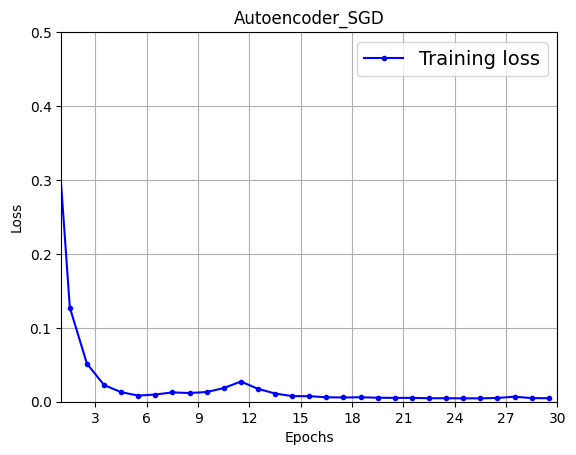

In [25]:
# loss 그래프 시각화
def plot_learning_curves(loss):
    plt.plot(np.arange(len(loss)) + 0.5, loss, "b.-", label="Training loss")
    # plt.plot(np.arange(len(accuracy)) + 1, accuracy, "r.-", label="Accuracy")
    plt.gca().xaxis.set_major_locator(mpl.ticker.MaxNLocator(integer=True))
    plt.axis([1, 30, 0, 0.5])
    plt.legend(fontsize=14)
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.grid(True)
plot_learning_curves(history.history["loss"])
plt.title("Autoencoder_SGD")
plt.show()

In [26]:
# 코딩
codings = encoder.predict(X_train)

2/2 [==============================] - 0s 7ms/step


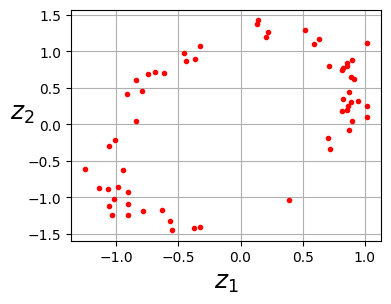

In [28]:
# 2D 사이즈에 인코딩
fig = plt.figure(figsize=(4,3))
plt.plot(codings[:,0], codings[:, 1], "r.")
plt.xlabel("$z_1$", fontsize=18)
plt.ylabel("$z_2$", fontsize=18, rotation=0)
plt.grid(True)
plt.show()

#### Stacked autoencoder 로드

In [98]:
# MNIST 데이터셋
(X_train, y_train), (X_test, y_test) =  keras.datasets.fashion_mnist.load_data()

In [99]:
# 검증셋, 훈련셋 분리
X_train = X_train.astype(np.float32)/255
X_test = X_test.astype(np.float32)/255
X_train, X_valid = X_train[:-5000], X_train[-5000:]
y_train, y_valid = y_train[:-5000], y_train[-5000:]

In [100]:
def rounded_accuracy(y_true, y_pred):
  return keras.metrics.binary_accuracy(tf.round(y_true) , tf.round(y_pred))

In [101]:
# stacked 모델
stacked_encoder = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.Dense(100, activation = "selu"),
    keras.layers.Dense(30, activation = "selu"),
])
stacked_decoder = keras.models.Sequential([
    keras.layers.Dense(100, activation = "selu", input_shape=[30]),
    keras.layers.Dense(28*28, activation = "sigmoid"),
    keras.layers.Reshape([28, 28]),
])
stacked_ae = keras.models.Sequential([stacked_encoder, stacked_decoder])

In [102]:
# 오토인코더 컴파일 - mse 실험
optimizer = keras.optimizers.Nadam()
stacked_ae.compile(loss="mse", optimizer = optimizer, metrics = [rounded_accuracy])

In [ ]:
# 학습 시작
history = stacked_ae.fit(X_train, X_train, epochs=20,
                         validation_data=(X_valid, X_valid), callbacks =tqdm_callback)

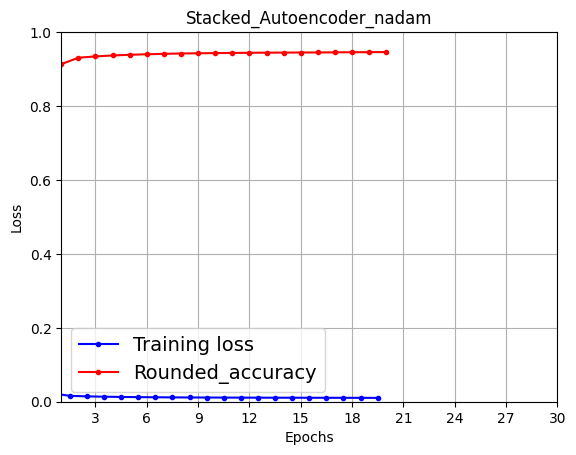

In [104]:
# loss 그래프 시각화
def plot_learning_curves(loss, rounded_accuracy):
    plt.plot(np.arange(len(loss)) + 0.5, loss, "b.-", label="Training loss")
    plt.plot(np.arange(len(rounded_accuracy)) + 1, rounded_accuracy, "r.-", label="Rounded_accuracy")
    plt.gca().xaxis.set_major_locator(mpl.ticker.MaxNLocator(integer=True))
    plt.axis([1, 30, 0, 1])
    plt.legend(fontsize=14)
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.grid(True)
plot_learning_curves(history.history["loss"], history.history["rounded_accuracy"])
plt.title("Stacked_Autoencoder_nadam")
plt.show()

1/1 [==============================] - 0s 42ms/step


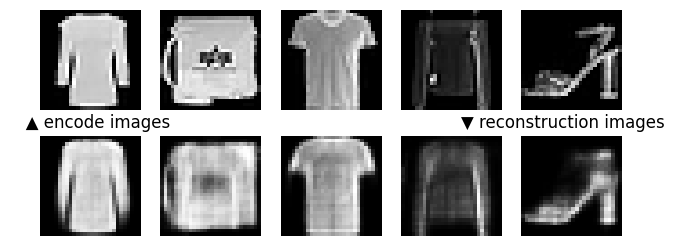

In [107]:
# 테스트 이미지 정의 함수
def plot_image(image):
  plt.imshow(image, cmap="gray")
  plt.axis("off")
def show_reconstructions(model, images = X_valid, n_images=5):
  reconstructions = model.predict(images[:n_images])
  fig = plt.figure(figsize=(n_images * 1.5, 3))
  for image_index in range(n_images):
    if image_index == 1:
      plt.title("   ▲ encode images")
    plt.subplot(2, n_images, 1+image_index)
    plot_image(images[image_index])
    plt.subplot(2, n_images, 1+n_images + image_index)
    plot_image(reconstructions[image_index])
  plt.title("▼ reconstruction images   ")
show_reconstructions(stacked_ae)

#### 그 외 시각화

In [108]:
from sklearn.manifold import TSNE
tsne = TSNE()
# TSNE > t분산 스토캐스틱 이웃 근접 사용. 변환
X_valid_compressed = stacked_encoder.predict(X_valid)
X_valid_2D = tsne.fit_transform(X_valid_compressed)
X_valid_2D = (X_valid_2D - X_valid_2D.min())/ (X_valid_2D.max() - X_valid_2D.min())

157/157 [==============================] - 0s 1ms/step


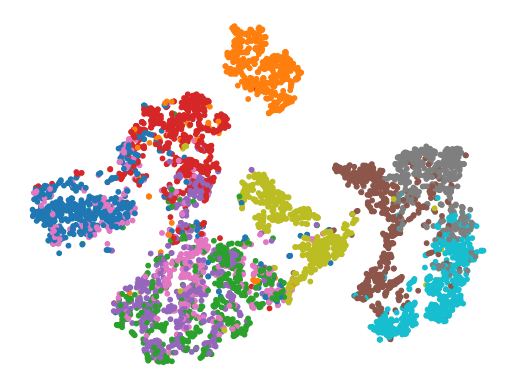

In [109]:
plt.scatter(X_valid_2D[:,0], X_valid_2D[:, 1], c = y_valid, s = 10, cmap="tab10")
plt.axis("off")
plt.show()

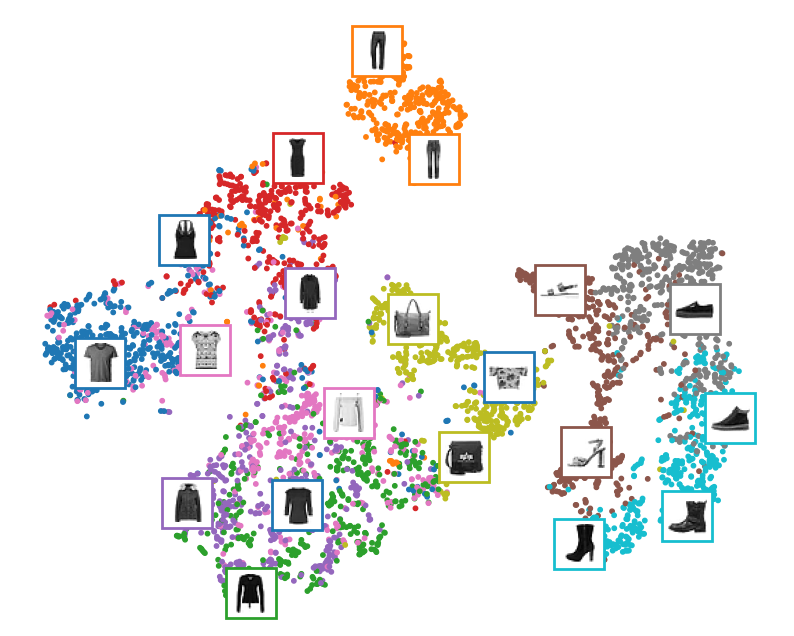

In [110]:
# 이미지와 함께 그래프 표출
plt.figure(figsize=(10, 8))
cmap = plt.cm.tab10
plt.scatter(X_valid_2D[:, 0], X_valid_2D[:, 1], c=y_valid, s=10, cmap=cmap)
image_positions = np.array([[1., 1.]])
for index, position in enumerate(X_valid_2D):
    dist = np.sum((position - image_positions) ** 2, axis=1)
    if np.min(dist) > 0.02: # if far enough from other images
        image_positions = np.r_[image_positions, [position]]
        imagebox = mpl.offsetbox.AnnotationBbox(
            mpl.offsetbox.OffsetImage(X_valid[index], cmap="binary"),
            position, bboxprops={"edgecolor": cmap(y_valid[index]), "lw": 2})
        plt.gca().add_artist(imagebox)
plt.axis("off")
plt.show()

#### Stacked Autoencoder를 통한 가중치 집합

In [113]:
class DenseTranspose(keras.layers.Layer):
    def __init__(self, dense, activation=None, **kwargs):
        self.dense = dense
        self.activation = keras.activations.get(activation)
        super().__init__(**kwargs)
    def build(self, batch_input_shape):
        self.biases = self.add_weight(name="bias",
                                      shape=[self.dense.input_shape[-1]],
                                      initializer="zeros")
        super().build(batch_input_shape)
    def call(self, inputs):
        z = tf.matmul(inputs, self.dense.weights[0], transpose_b=True)
        return self.activation(z + self.biases)

In [114]:
# 모델 정의
keras.backend.clear_session()
dense_1 = keras.layers.Dense(100, activation = "selu")
dense_2 = keras.layers.Dense(30, activation = "selu")
tied_encoder = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    dense_1,
    dense_2
])

tied_decoder = keras.models.Sequential([
    DenseTranspose(dense_2, activation="selu"),
    DenseTranspose(dense_1, activation="sigmoid"),
    keras.layers.Reshape([28, 28])
])

tied_ae = keras.models.Sequential([tied_encoder, tied_decoder])

In [115]:
# 오토인코더 컴파일 - nadam 실험
optimizer = keras.optimizers.Nadam()
stacked_ae.compile(loss="binary_crossentropy", optimizer = optimizer, metrics = [rounded_accuracy])

In [ ]:
# 학습 시작
history = stacked_ae.fit(X_train, X_train, epochs=30,
                         validation_data=(X_valid, X_valid), callbacks =tqdm_callback)

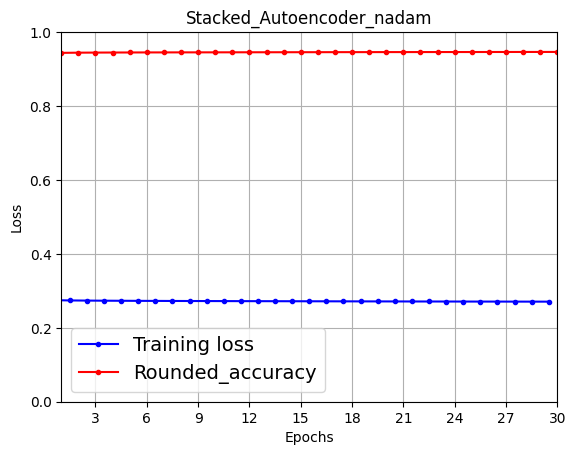

In [118]:
# loss 그래프 시각화
def plot_learning_curves(loss, rounded_accuracy):
    plt.plot(np.arange(len(loss)) + 0.5, loss, "b.-", label="Training loss")
    plt.plot(np.arange(len(rounded_accuracy)) + 1, rounded_accuracy, "r.-", label="Rounded_accuracy")
    plt.gca().xaxis.set_major_locator(mpl.ticker.MaxNLocator(integer=True))
    plt.axis([1, 30, 0, 1])
    plt.legend(fontsize=14)
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.grid(True)
plot_learning_curves(history.history["loss"], history.history["rounded_accuracy"])
plt.title("Stacked_Autoencoder_nadam")
plt.show()

1/1 [==============================] - 0s 331ms/step


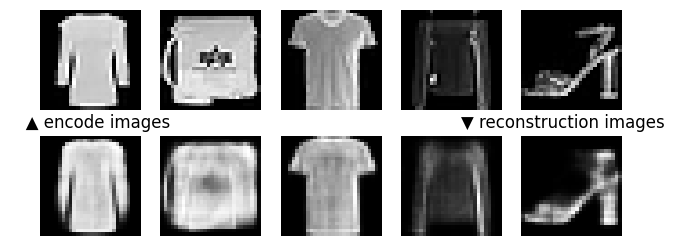

In [119]:
# 테스트 이미지 정의 함수
def plot_image(image):
  plt.imshow(image, cmap="gray")
  plt.axis("off")
def show_reconstructions(model, images = X_valid, n_images=5):
  reconstructions = model.predict(images[:n_images])
  fig = plt.figure(figsize=(n_images * 1.5, 3))
  for image_index in range(n_images):
    if image_index == 1:
      plt.title("   ▲ encode images")
    plt.subplot(2, n_images, 1+image_index)
    plot_image(images[image_index])
    plt.subplot(2, n_images, 1+n_images + image_index)
    plot_image(reconstructions[image_index])
  plt.title("▼ reconstruction images   ")
show_reconstructions(stacked_ae)

157/157 [==============================] - 0s 2ms/step


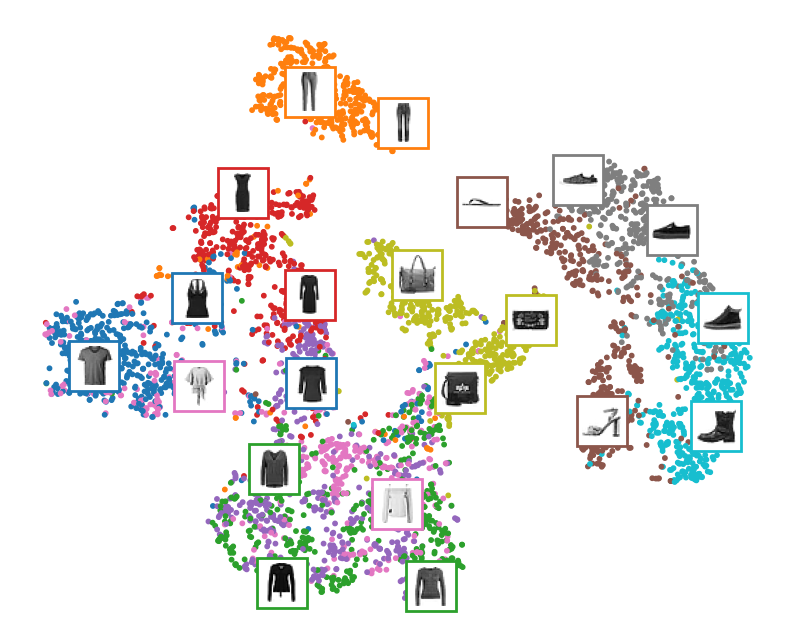

In [120]:
X_valid_compressed = stacked_encoder.predict(X_valid)
X_valid_2D = tsne.fit_transform(X_valid_compressed)
X_valid_2D = (X_valid_2D - X_valid_2D.min())/ (X_valid_2D.max() - X_valid_2D.min())
# 이미지와 함께 그래프 표출
plt.figure(figsize=(10, 8))
cmap = plt.cm.tab10
plt.scatter(X_valid_2D[:, 0], X_valid_2D[:, 1], c=y_valid, s=10, cmap=cmap)
image_positions = np.array([[1., 1.]])
for index, position in enumerate(X_valid_2D):
    dist = np.sum((position - image_positions) ** 2, axis=1)
    if np.min(dist) > 0.02: # if far enough from other images
        image_positions = np.r_[image_positions, [position]]
        imagebox = mpl.offsetbox.AnnotationBbox(
            mpl.offsetbox.OffsetImage(X_valid[index], cmap="binary"),
            position, bboxprops={"edgecolor": cmap(y_valid[index]), "lw": 2})
        plt.gca().add_artist(imagebox)
plt.axis("off")
plt.show()